## Figure 1: Gencode Analyses: TF isoform annotations, expression patterns, domains

In [1]:
import os
import itertools
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from poibin import PoiBin
import pandas as pd
import sys


# import utils
sys.path.append("../")

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_annotated_gencode_tfs,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_seq_comparison_data,
                          load_gtex_gencode,
                          load_developmental_tissue_expression_gencode,
                          load_tf_families,
                          load_pfam_clans,
                          load_DNA_binding_domains)

In [2]:
np.random.seed(2023)

In [3]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## 1. load Gencode TFs + GTEx + Dev RNA-seq

In [5]:
tfs = load_annotated_gencode_tfs()

df_gtex, metadata_gtex, genes_gtex = load_gtex_gencode()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_gencode()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())
all_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values() for orf in tf.isoforms}
alt_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and not orf.is_MANE_select_transcript}
ref_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript}

reading from cache
reading from cache
reading from cache


In [6]:
len(tfs)

1635

In [7]:
metadata_dev.shape

(313, 42)

In [8]:
metadata_gtex.shape

(2485, 49)

In [9]:
len(all_isos)

4144

In [10]:
len(ref_isos)

1514

In [11]:
len(alt_isos)

2305

In [12]:
(means_gtex > 1).any(axis=1).value_counts()

True     3165
False     979
dtype: int64

In [13]:
(means_gtex.loc[means_gtex.index.isin(alt_isos), :].sum(axis=1) >= 1).sum()

1842

## 2. isoforms per family

In [14]:
# number of isoforms vs gene expression, publications, and exons 
tpm_per_gene = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .sum()
                .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                .mean())
gn = tpm_per_gene.max(axis=1).rename('TPM - gene-level, max across GTEx tissues').to_frame()
gn['n_isoforms'] = gn.index.map(genes_gtex.value_counts())

In [15]:
fam = load_tf_families()
gn['family'] = gn.index.map(fam)
gn['is_nuclear_receptor'] = (gn['family'] == 'Nuclear receptor')
gn.head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
AC008770.3,0.339530,2,C2H2 ZF,False
AC023509.3,4.475325,1,bZIP,False
AC092835.1,0.884619,1,C2H2 ZF,False
AC138696.1,1.760060,1,C2H2 ZF,False
ADNP,9157.752828,3,Homeodomain,False


In [16]:
len(gn)

1635

In [17]:
len(gn[gn["n_isoforms"] > 1])

992

In [18]:
gn.n_isoforms.mean()

2.5345565749235472

In [19]:
gn[gn["family"] == "Homeodomain"].n_isoforms.mean()

1.8041237113402062

In [20]:
gn[gn["family"] == "Nuclear receptor"].n_isoforms.mean()

3.8260869565217392

In [21]:
gn.sort_values(by="n_isoforms", ascending=False).head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
CREM,372.514410,25,bZIP,False
TCF4,13.551768,23,bHLH,False
NFATC4,198.651682,23,Rel,False
NR1I3,65.437841,21,Nuclear receptor,True
MYT1L,47.689698,18,C2H2 ZF,False


In [22]:
fam_members = pd.DataFrame(gn['family'].value_counts()).reset_index()
fam_members_ov20 = fam_members[fam_members["family"] >= 20]
fam_members_ov20

,index,family
0,C2H2 ZF,745
1,Homeodomain,194
2,bHLH,108
3,Unknown,69
4,bZIP,54
5,Forkhead,49
6,Nuclear receptor,46
7,HMG/Sox,30
8,Ets,27


In [23]:
def collapse_families(row, families_to_keep):
    if row['family'] in families_to_keep:
        return row['family']
    else:
        return 'Other'
    
gn['family_updated'] = gn.apply(collapse_families, axis=1, 
                                families_to_keep=list(fam_members[fam_members['family'] >=20]['index']))
gn.family_updated.value_counts()

C2H2 ZF             745
Other               313
Homeodomain         194
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
Name: family_updated, dtype: int64

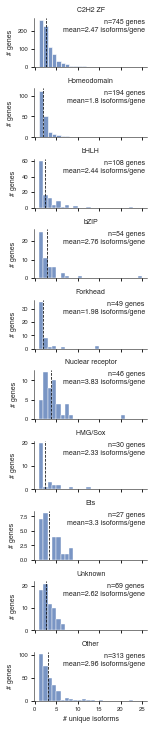

In [24]:
def annotate(data, **kws):
    n = len(data)
    mean = data.n_isoforms.mean()
    ax = plt.gca()
    ax.text(0.98, 0.98, "n=%s genes\nmean=%s isoforms/gene" % (n, np.round(mean, 2)), transform=ax.transAxes,
            ha="right", va="top")
    ax.axvline(x=mean, linestyle="dashed", color="black", linewidth=0.75)

g = sns.FacetGrid(gn, row="family_updated", sharex=True, sharey=False, height=1, aspect=2,
                  row_order=["C2H2 ZF", "Homeodomain", "bHLH", "bZIP", "Forkhead", "Nuclear receptor",
                             "HMG/Sox", "Ets", "Unknown", "Other"])
g.map_dataframe(sns.histplot, "n_isoforms", binwidth=1)
g.map_dataframe(annotate)
g.set_axis_labels("# unique isoforms", "# genes")
g.set_titles(row_template="{row_name}")
g.savefig("../../figures/fig1/GENCODE_iso_counts_per_family.pdf", bbox_inches="tight", dpi="figure")

## 3. downsample GTEx

GTEx has more samples per condition than Dev, but Dev has more conditions

In [25]:
# conditions (body sites): gtex
len(metadata_gtex['body_site'].value_counts())

51

In [26]:
# samples per body site: gtex
metadata_gtex['body_site'].value_counts()

Lung                                         379
Thyroid                                      360
Colon - Transverse                           206
Colon - Sigmoid                              173
Adrenal Gland                                161
Liver                                        138
Kidney - Cortex                               36
Breast - Mammary Tissue                       35
Whole Blood                                   33
Muscle - Skeletal                             32
Skin - Not Sun Exposed (Suprapubic)           32
Skin - Sun Exposed (Lower leg)                29
Adipose - Subcutaneous                        27
Heart - Left Ventricle                        24
Brain - Spinal cord (cervical c-1)            24
Brain - Frontal Cortex (BA9)                  24
Testis                                        24
Brain - Caudate (basal ganglia)               24
Brain - Putamen (basal ganglia)               24
Prostate                                      24
Brain - Cerebellar H

In [27]:
# conditions (body sites): dev
metadata_dev['body_site'] = metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']
len(metadata_dev['body_site'].value_counts())

127

In [28]:
# samples per body site: dev
metadata_dev['body_site'].value_counts()

hindbrain neonate        5
heart 08                 5
forebrain young adult    5
hindbrain young adult    5
forebrain 19             5
                        ..
liver adult              1
heart adolescent         1
ovary 16                 1
ovary 09                 1
liver child              1
Name: body_site, Length: 127, dtype: int64

### loop through GTEx tissues and pick the # of samples by randomly matching to a dev dataset
this is inherently unstable when sampling w/o replacement as will end up with times where there are more samps in the dev that you're randomly matching to than the gtex (rare but happens)

In [29]:
# loop through gtex tissues
# pick number of samples according to dev dataset
# loop again
# make fake metadata file
n_samples_dev = df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).value_counts().values
np.random.shuffle(n_samples_dev)
gtex_tissues = metadata_gtex['body_site'].value_counts().index.values

metadata_gtex_dummy = {}
for i, (n_samples, tissue) in enumerate(zip(n_samples_dev, itertools.cycle(gtex_tissues))):
    metadata_gtex_dummy[tissue + '_' + str(i)] = (metadata_gtex.loc[(metadata_gtex['body_site'] == tissue)
                                                                    & ~metadata_gtex.index.isin({s for samples in metadata_gtex_dummy.values() for s in samples}),
                                                                    :]
                                                        .sample(n_samples).index.values)

# TODO: check it is sampling with replacement and ends up same size as dev   
# NOTE: this block of code is unstable depending on seed

metadata_gtex_dummy = (pd.Series({v: k for k, vs in metadata_gtex_dummy.items() for v in vs}, name='body_site')
                         .to_frame())

if metadata_dev.shape[0] != metadata_gtex_dummy.shape[0]:
    raise UserWarning('Problem with downsampling code')
if sorted(n_samples_dev) != sorted(metadata_gtex_dummy.groupby('body_site').size().values):
    raise UserWarning('Problem with downsampling code')
if metadata_gtex_dummy.index.duplicated().any():
    raise UserWarning('Unexpected duplicates')

In [30]:
metadata_gtex_dummy.shape

(313, 1)

In [31]:
len(metadata_gtex_dummy.body_site.unique())

127

In [32]:
len(metadata_gtex_dummy.body_site.str.split("_", expand=True)[0].unique())

51

In [33]:
metadata_dev.shape

(313, 43)

In [34]:
len(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique())

127

In [35]:
df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique()

Index(['liver 12', 'ovary 13', 'hindbrain infant', 'liver adult', 'kidney 12',
       'kidney 10', 'hindbrain adolescent', 'heart 11', 'testis 06',
       'kidney 07',
       ...
       'liver 13', 'kidney 05', 'testis adult', 'ovary 06', 'ovary 05',
       'hindbrain 09', 'kidney toddler', 'forebrain 12', 'testis 12',
       'kidney child'],
      dtype='object', length=127)

In [36]:
tmp = metadata_dev.groupby(["organism_part", "dev_stage"])["BioSample"].agg("count").reset_index()
tmp.sort_values(by="BioSample")

,organism_part,dev_stage,BioSample
103,ovary,11,1
31,heart,18,1
106,ovary,16,1
33,heart,adolescent,1
58,kidney,04,1
...,...,...,...
55,hindbrain,neonate,5
57,hindbrain,young adult,5
19,forebrain,young adult,5
24,heart,08,5


#### this dataframe is now the same shape as the dev data in both # of samples and # of "sites"
gets to the same # of "sites" by re-sampling among GTEx tissues

In [37]:
# write this file so we can load it in the DN section later
metadata_gtex_dummy.to_csv("../../data/processed/metadata_gtex_dummy.csv")

In [38]:
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

## 4. histograms: isoforms per gene + thresholded on expression

### GTEx: all

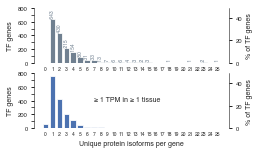

In [39]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.5, 2.2))

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs], color="slategrey")

# label n
for h, x in zip([n_iso.value_counts().to_dict().get(x, 0) for x in xs], xs):
    if h == 0:
        continue
    axs[0].text(x, h, " %s" % h, rotation=90, fontsize=fontsize-2, ha="center", va="bottom",
                color="slategrey")

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[0].set_xticks(xs)
axs[0].set_xlabel("Unique annotated protein isoforms per gene")
axs[0].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xticks(xs)
axs[1].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xlabel('Unique protein isoforms per gene')
#axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in ≥ 1 tissue')

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx.pdf',
            bbox_inches='tight')

### GTEx: downsample

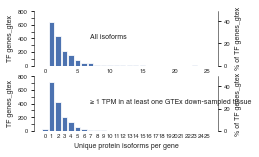

In [40]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one GTEx down-sampled tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_gtex')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_gtex')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_downsamp.pdf',
            bbox_inches='tight')

### Dev

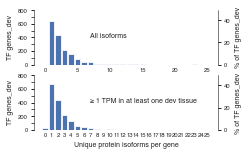

In [41]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one dev tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_dev')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_dev')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_dev.pdf',
            bbox_inches='tight')

## 5. ref v alt 2D heatmaps: max expression

In [42]:
ref_alt_map = pd.DataFrame([ref_isos]).T
ref_alt_map.columns = ["ref"]
ref_alt_map["gene"] = ref_alt_map["ref"].str.split("|", expand=True)[0].str[:-4]

alt_isos_df = pd.DataFrame([alt_isos]).T
alt_isos_df.columns = ["alt"]
alt_isos_df["gene"] = alt_isos_df["alt"].str.split("|", expand=True)[0].str[:-4]

ref_alt_map = ref_alt_map.merge(alt_isos_df, on="gene", how="left")
print(len(ref_alt_map))
ref_alt_map_nonan = ref_alt_map[~pd.isnull(ref_alt_map["alt"])]
print(len(ref_alt_map_nonan))
ref_alt_map_nonan.head()

2910
2305


,ref,gene,alt
3,CXXC1-201,CXXC1,CXXC1-212
4,CXXC1-201,CXXC1,CXXC1-202
6,ZNF207-203,ZNF207,ZNF207-202
7,ZNF207-203,ZNF207,ZNF207-201
8,ZNF207-203,ZNF207,ZNF207-204


In [43]:
ref_alt_map_nonan[ref_alt_map_nonan["gene"] == "NKX2-5"]

,ref,gene,alt
2720,NKX2-5-201,NKX2-5,NKX2-5-202
2721,NKX2-5-201,NKX2-5,NKX2-5-204


### GTEx: all

In [44]:
means_gtex["max_gtex"] = means_gtex.max(axis=1)
means_gtex["min_gtex"] = means_gtex.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex[means_gtex["max_gtex"] > 11] = 11

print(means_gtex["max_gtex"].max())
print(means_gtex["max_gtex"].min())
means_gtex_ri = means_gtex.reset_index()
means_gtex_ri["UID_rep"] = means_gtex_ri["UID"].str.replace("_", "|")

11.0
0.0


In [45]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1775
529


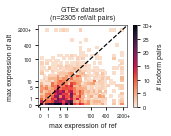

In [46]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_ref", y="max_gtex_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max expression of ref")
ax.set_ylabel("max expression of alt")
ax.set_title("GTEx dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] > ref_alt_map_nonan["max_gtex_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] < ref_alt_map_nonan["max_gtex_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-gtex.pdf',
            bbox_inches='tight')

### GTEx: downsampled

In [47]:
means_gtex_downsample["max_gtex_downsample"] = means_gtex_downsample.max(axis=1)
means_gtex_downsample["min_gtex_downsample"] = means_gtex_downsample.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex_downsample[means_gtex_downsample["max_gtex_downsample"] > 11] = 11

print(means_gtex_downsample["max_gtex_downsample"].max())
print(means_gtex_downsample["max_gtex_downsample"].min())
means_gtex_downsample_ri = means_gtex_downsample.reset_index()
means_gtex_downsample_ri["UID_rep"] = means_gtex_downsample_ri["UID"].str.replace("_", "|")

11.0
0.0


In [48]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="ref", right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="alt", right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1783
521


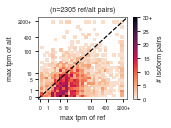

In [49]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_downsample_ref", y="max_gtex_downsample_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max tpm of ref")
ax.set_ylabel("max tpm of alt")
ax.set_title("(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] > ref_alt_map_nonan["max_gtex_downsample_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] < ref_alt_map_nonan["max_gtex_downsample_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-gtex-downsample.pdf',
            bbox_inches='tight')

### Dev

In [50]:
means_dev["max_dev"] = means_dev.max(axis=1)
means_dev["min_dev"] = means_dev.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_dev[means_dev["max_dev"] > 11] = 11

print(means_dev["max_dev"].max())
print(means_dev["max_dev"].min())
means_dev_ri = means_dev.reset_index()
means_dev_ri["UID_rep"] = means_dev_ri["UID"].str.replace("_", "|")

11.0
0.0


In [51]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1752
551


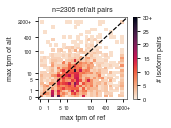

In [52]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_dev_ref", y="max_dev_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max tpm of ref")
ax.set_ylabel("max tpm of alt")
ax.set_title("n=%s ref/alt pairs" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] > ref_alt_map_nonan["max_dev_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] < ref_alt_map_nonan["max_dev_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-dev.pdf',
            bbox_inches='tight')

## 6. per isoform: max v min ratio

removing NaNs - not counting anything where *gene* expression < 1

### GTEx: all

In [53]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# fraction where gene tpm > 1

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [54]:
print(len(f_gtex))
f_gtex["max_ratio_gtex"] = f_gtex.max(axis=1)
f_gtex["min_ratio_gtex"] = f_gtex.min(axis=1)
f_gtex_nonan = f_gtex[(~pd.isnull(f_gtex["max_ratio_gtex"])) & (~pd.isnull(f_gtex["min_ratio_gtex"]))]
print(len(f_gtex_nonan))

f_gtex_ri = f_gtex_nonan.reset_index()
f_gtex_ri["UID_rep"] = f_gtex_ri["UID"].str.replace("_", "|")

4144
4095


In [55]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

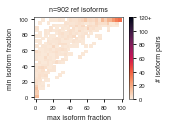

In [56]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["ref", "min_ratio_gtex_ref", "max_ratio_gtex_ref"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_ref"])) & (~pd.isnull(df["max_ratio_gtex_ref"]))]

ax = sns.histplot(data=df, x="min_ratio_gtex_ref", y="max_ratio_gtex_ref",
                  bins=30, cbar=True, cmap="rocket_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("max isoform fraction")
ax.set_ylabel("min isoform fraction")
ax.set_title("n=%s ref isoforms" % len(df))

fig.savefig('../../figures/fig1/expression-ratio-scatter-ref-gtex.pdf',
            bbox_inches='tight')

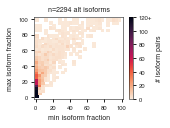

In [57]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["alt", "min_ratio_gtex_alt", "max_ratio_gtex_alt"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_alt"])) & (~pd.isnull(df["max_ratio_gtex_alt"]))]

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_gtex_alt", y="max_ratio_gtex_alt",
                  bins=30, cbar=True, cmap="rocket_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))
fig.savefig('../../figures/fig1/expression-ratio-scatter-alt-gtex.pdf',
            bbox_inches='tight')

### GTEx: downsample

In [58]:
MIN_THRESH = 10
MAX_THRESH = 90

In [59]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

In [60]:
print(len(f_gtex_downsample))
f_gtex_downsample["max_ratio_gtex_downsample"] = f_gtex_downsample.max(axis=1)
f_gtex_downsample["min_ratio_gtex_downsample"] = f_gtex_downsample.min(axis=1)
f_gtex_downsample_nonan = f_gtex_downsample[(~pd.isnull(f_gtex_downsample["max_ratio_gtex_downsample"])) & 
                                            (~pd.isnull(f_gtex_downsample["min_ratio_gtex_downsample"]))]
print(len(f_gtex_downsample_nonan))

f_gtex_downsample_ri = f_gtex_downsample_nonan.reset_index()
f_gtex_downsample_ri["UID_rep"] = f_gtex_downsample_ri["UID"].str.replace("_", "|")

4144
4100


In [61]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                       "min_ratio_gtex_downsample"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                                  "min_ratio_gtex_downsample"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

52


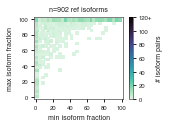

In [62]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["ref", "min_ratio_gtex_downsample_ref", "max_ratio_gtex_downsample_ref"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_downsample_ref"])) & (~pd.isnull(df["max_ratio_gtex_downsample_ref"]))]

n_switches = df[(df["min_ratio_gtex_downsample_ref"] < MIN_THRESH) & (df["max_ratio_gtex_downsample_ref"] > MAX_THRESH)]
n_off = df[(df["min_ratio_gtex_downsample_ref"] < MIN_THRESH) & (df["max_ratio_gtex_downsample_ref"] < MIN_THRESH)]
print(len(n_switches))
p_switches_ref_gtex_ds = len(n_switches)/len(df)
p_off_ref_gtex_ds = len(n_off)/len(df)

ax = sns.histplot(data=df, x="min_ratio_gtex_downsample_ref", y="max_ratio_gtex_downsample_ref",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s ref isoforms" % len(df))
fig.savefig('../../figures/fig1/expression-ratio-scatter-ref-gtex-downsample.pdf',
            bbox_inches='tight')

54


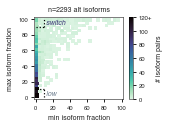

In [63]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["alt", "min_ratio_gtex_downsample_alt", "max_ratio_gtex_downsample_alt"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_downsample_alt"])) & (~pd.isnull(df["max_ratio_gtex_downsample_alt"]))]

n_switches = df[(df["min_ratio_gtex_downsample_alt"] < MIN_THRESH) & (df["max_ratio_gtex_downsample_alt"] > MAX_THRESH)]
n_off = df[(df["min_ratio_gtex_downsample_alt"] < MIN_THRESH) & (df["max_ratio_gtex_downsample_alt"] < MIN_THRESH)]
print(len(n_switches))
p_switches_alt_gtex_ds = len(n_switches)/len(df)
p_off_alt_gtex_ds = len(n_off)/len(df)

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_gtex_downsample_alt", y="max_ratio_gtex_downsample_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([MIN_THRESH, 0], [MIN_THRESH, MIN_THRESH], linestyle="dotted", color="black")
ax.plot([MIN_THRESH, MIN_THRESH], [0, MIN_THRESH], linestyle="dotted", color="black")
ax.plot([0, MIN_THRESH], [MAX_THRESH, MAX_THRESH], linestyle="dotted", color="black")
ax.plot([MIN_THRESH, MIN_THRESH], [MAX_THRESH, 100], linestyle="dotted", color="black")
ax.text(MIN_THRESH, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.text(MIN_THRESH, MAX_THRESH+5, " switch", ha="left", va="center", fontstyle="italic", color=sns.color_palette("mako")[1])

fig.savefig('../../figures/fig1/expression-ratio-scatter-alt-gtex-downsample.pdf',
            bbox_inches='tight')

### Dev

In [64]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [65]:
print(len(f_dev))
f_dev["max_ratio_dev"] = f_dev.max(axis=1)
f_dev["min_ratio_dev"] = f_dev.min(axis=1)
f_dev_nonan = f_dev[(~pd.isnull(f_dev["max_ratio_dev"])) & (~pd.isnull(f_dev["min_ratio_dev"]))]
print(len(f_dev_nonan))

f_dev_ri = f_dev_nonan.reset_index()
f_dev_ri["UID_rep"] = f_dev_ri["UID"].str.replace("_", "|")

4144
4119


In [66]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

150


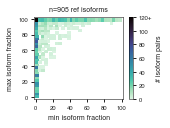

In [67]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["ref", "min_ratio_dev_ref", "max_ratio_dev_ref"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_dev_ref"])) & (~pd.isnull(df["max_ratio_dev_ref"]))]

n_switches = df[(df["min_ratio_dev_ref"] < MIN_THRESH) & (df["max_ratio_dev_ref"] > MAX_THRESH)]
n_off = df[(df["min_ratio_dev_ref"] < MIN_THRESH) & (df["max_ratio_dev_ref"] < MIN_THRESH)]
print(len(n_switches))
p_switches_ref_dev = len(n_switches)/len(df)
p_off_ref_dev = len(n_off)/len(df)

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_dev_ref", y="max_ratio_dev_ref",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s ref isoforms" % len(df))

fig.savefig('../../figures/fig1/expression-ratio-scatter-ref-dev.pdf',
            bbox_inches='tight')

165


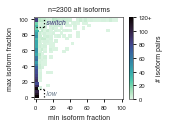

In [68]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["alt", "min_ratio_dev_alt", "max_ratio_dev_alt"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_dev_alt"])) & (~pd.isnull(df["max_ratio_dev_alt"]))]

n_switches = df[(df["min_ratio_dev_alt"] < MIN_THRESH) & (df["max_ratio_dev_alt"] > MAX_THRESH)]
n_off = df[(df["min_ratio_dev_alt"] < MIN_THRESH) & (df["max_ratio_dev_alt"] < MIN_THRESH)]
print(len(n_switches))
p_switches_alt_dev = len(n_switches)/len(df)
p_off_alt_dev = len(n_off)/len(df)

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_dev_alt", y="max_ratio_dev_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([MIN_THRESH, 0], [MIN_THRESH, MIN_THRESH], linestyle="dotted", color="black")
ax.plot([MIN_THRESH, MIN_THRESH], [0, MIN_THRESH], linestyle="dotted", color="black")
ax.plot([0, MIN_THRESH], [MAX_THRESH, MAX_THRESH], linestyle="dotted", color="black")
ax.plot([MIN_THRESH, MIN_THRESH], [MAX_THRESH, 100], linestyle="dotted", color="black")
ax.text(MIN_THRESH, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.text(MIN_THRESH, MAX_THRESH+5, " switch", ha="left", va="center", fontstyle="italic", color=sns.color_palette("mako")[1])

fig.savefig('../../figures/fig1/expression-ratio-scatter-alt-dev.pdf',
            bbox_inches='tight')

In [69]:
bar = pd.DataFrame.from_dict({"gtex_ds_ref": {"switch": p_switches_ref_gtex_ds*100, "low": p_off_ref_gtex_ds*100},
                              "gtex_ds_alt": {"switch": p_switches_alt_gtex_ds*100, "low": p_off_alt_gtex_ds*100},
                              "dev_ref": {"switch": p_switches_ref_dev*100, "low": p_off_ref_dev*100},
                              "dev_alt": {"switch": p_switches_alt_dev*100, "low": p_off_alt_dev*100}}, 
                             orient="index").reset_index()
bar["shift"] = 100-(bar["switch"]+bar["low"])
bar = bar[["index", "low", "switch", "shift"]]
bar

,index,low,switch,shift
0,gtex_ds_ref,2.549889,5.764967,91.685144
1,gtex_ds_alt,21.412996,2.354993,76.232010
2,dev_ref,2.320442,16.574586,81.104972
3,dev_alt,15.000000,7.173913,77.826087


In [70]:
palette = {"low": "lightgrey",
           "switch": sns.color_palette("mako")[1],
           "shift": sns.color_palette("mako")[5]}
palette

{'low': 'lightgrey',
 'switch': (0.25307401, 0.23772973, 0.48316271),
 'shift': (0.54578602, 0.8544913, 0.69848331)}

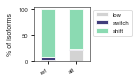

In [71]:
gtex_bar = bar[bar["index"].str.contains("gtex")]
ax = gtex_bar.plot.bar(x="index", stacked=True, color=palette.values(), figsize=(1, 1))
ax.set_ylabel("% of isoforms")
ax.set_xlabel("")
#ax.set_title("GTEx")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(["ref", "alt"], ha="right", va="top", rotation=30)

plt.savefig('../../figures/fig1/expression-switch-bar-gtex.pdf',
            bbox_inches='tight')

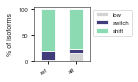

In [72]:
dev_bar = bar[bar["index"].str.contains("dev")]
ax = dev_bar.plot.bar(x="index", stacked=True, color=palette.values(), figsize=(1, 1))
ax.set_ylabel("% of isoforms")
ax.set_xlabel("")
#ax.set_title("dev")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(["ref", "alt"], ha="right", va="top", rotation=30)

plt.savefig('../../figures/fig1/expression-switch-bar-dev.pdf',
            bbox_inches='tight')

### example plot: TF gene whose isoform ratios change across tissues

In [73]:
tmp = ref_alt_map_nonan
tmp["mm_gtex_ds_ref"] = tmp["max_ratio_gtex_downsample_ref"]-tmp["min_ratio_gtex_downsample_ref"]
tmp["mm_gtex_ds_alt"] = tmp["max_ratio_gtex_downsample_alt"]-tmp["min_ratio_gtex_downsample_alt"]
tmp["mm_dev_ref"] = tmp["max_ratio_dev_ref"]-tmp["min_ratio_dev_ref"]
tmp["mm_dev_alt"] = tmp["max_ratio_dev_alt"]-tmp["min_ratio_dev_alt"]
tmp["dg_ref"] = tmp["mm_dev_ref"]-tmp["mm_gtex_ds_ref"]
tmp["dg_alt"] = tmp["mm_dev_alt"]-tmp["mm_gtex_ds_alt"]
#tmp.sort_values(by="dg_alt", ascending=False).head(30)

In [74]:
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex

In [75]:
def developmental_tissue_expression_plot(gene_name, palette_name, figsize, ylim, means, cols, fig_suffix):
    n_isos = len(means.loc[genes == gene_name])
    palette = sns.color_palette(palette_name, as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[genes == gene_name, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig1/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

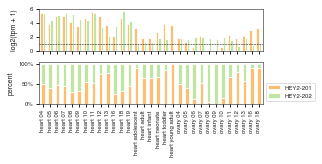

In [76]:
heart_cols = [x for x in means_dev.columns if "heart" in x]
ovary_cols = [x for x in means_dev.columns if "ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (4, 1.75), (0, 6), means_dev, heart_cols + ovary_cols, 
                                     "means_dev_heart_ovary")

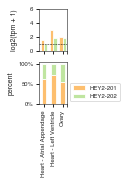

In [77]:
heart_cols = [x for x in means_gtex.columns if "Heart" in x]
ovary_cols = [x for x in means_gtex.columns if "Ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (0.5, 1.75), (0, 6), means_gtex, heart_cols + ovary_cols, 
                                     "means_gtex_heart_ovary")

In [78]:
ss_alt_gtex = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_gtex_downsample_alt"] > MIN_THRESH)].gene.unique())
ss_alt_gtex

851

In [79]:
ss_alt_dev = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_dev_alt"] > MIN_THRESH)].gene.unique())
ss_alt_dev

877

In [80]:
tot_genes = len(ref_alt_map_nonan.gene.unique())
tot_genes

909

In [81]:
ss_alt_gtex/tot_genes

0.9361936193619362

In [82]:
ss_alt_dev/tot_genes

0.9647964796479648

## 7. calculate domain switches in annotated isoforms

In [83]:
# loop through ref/alt pairs above and calculate total num AAs inserted/deleted/frameshifted
tot_ins = []
tot_perc_ins = []
tot_dd = []
tot_perc_dd = []
tot_f = []
tot_perc_f = []

tot_ins_dom = []
tot_perc_ins_dom = []
tot_dd_dom = []
tot_perc_dd_dom = []
tot_f_dom = []
tot_perc_f_dom = []

tot_ins_eff = []
tot_perc_ins_eff = []
tot_dd_eff = []
tot_perc_dd_eff = []
tot_f_eff = []
tot_perc_f_eff = []

for i, row in ref_alt_map_nonan.iterrows():
    ref = row.ref.split("|")[0]
    alt = row.alt.split("|")[0]
    gene = ref[:-4]
    
    # manual fixes
    if gene == "AC092072.1":
        gene = "ZNF223"
    if gene == "AC008554.1":
        gene = "ZNF737"
    if gene == "AC073611.1":
        gene = "SP7"
    if gene == "AC118549.1":
        gene = "ZZZ3"
    if gene == "ZUP1":
        gene = "ZUFSP"
    if gene == "AC139768.1":
        gene = "POU6F1"
    if gene == "PHF19":
        gene = "PHF19 "
    #print("gene: %s | ref: %s | alt: %s" % (gene, ref, alt))
    
    pp_str = tfs[gene].pairwise_changes_relative_to_reference(ref, alt)
    aa_ftr = tfs[gene].aa_feature_disruption(ref)
    if len(aa_ftr) == 0:
        ins_dom = 0
        perc_ins_dom = 0
        dd_dom = 0
        perc_dd_dom = 0
        f_dom = 0
        perc_f_dom = 0
        
        ins_eff = 0
        perc_ins_eff = 0
        dd_eff = 0
        perc_dd_eff = 0
        f_eff = 0
        perc_f_eff = 0
    else:
        aa_ftr_alt = aa_ftr[aa_ftr["alt_iso"] == alt]
        
        # separate pfam and effector domains
        pfam = aa_ftr_alt[aa_ftr_alt["category"] == "Pfam_domain"]
        eff = aa_ftr_alt[aa_ftr_alt["category"] == "effector_domain"]
        
        if len(pfam) > 0:
            pfam_grp = pfam.groupby("alt_iso")[["deletion", "insertion", "frameshift"]].agg("sum").reset_index()
        
            ins_dom = pfam_grp.insertion.iloc[0]
            perc_ins_dom = ins_dom/len(pp_str)*100
            dd_dom = pfam_grp.deletion.iloc[0]
            perc_dd_dom = dd_dom/len(pp_str)*100
            f_dom = pfam_grp.frameshift.iloc[0]
            perc_f_dom = f_dom/len(pp_str)*100
        else:
            ins_dom = 0
            perc_ins_dom = 0
            dd_dom = 0
            perc_dd_dom = 0
            f_dom = 0
            perc_f_dom = 0
            
        if len(eff) > 0:
            eff_grp = eff.groupby("alt_iso")[["deletion", "insertion", "frameshift"]].agg("sum").reset_index()
        
            ins_eff = eff_grp.insertion.iloc[0]
            perc_ins_eff = ins_eff/len(pp_str)*100
            dd_eff = eff_grp.deletion.iloc[0]
            perc_dd_eff = dd_eff/len(pp_str)*100
            f_eff = eff_grp.frameshift.iloc[0]
            perc_f_eff = f_eff/len(pp_str)*100
        else:
            ins_eff = 0
            perc_ins_eff = 0
            dd_eff = 0
            perc_dd_eff = 0
            f_eff = 0
            perc_f_eff = 0
        
        
    
    
    ins = pp_str.count("I")
    perc_ins = ins/len(pp_str)*100
    dd = pp_str.count("D")
    perc_dd = dd/len(pp_str)*100
    f = pp_str.count("F")
    f += pp_str.count("f")
    perc_f = f/len(pp_str)*100
    
    tot_ins.append(ins)
    tot_perc_ins.append(perc_ins)
    tot_dd.append(dd)
    tot_perc_dd.append(perc_dd)
    tot_f.append(f)
    tot_perc_f.append(perc_f)
    
    tot_ins_dom.append(ins_dom)
    tot_perc_ins_dom.append(perc_ins_dom)
    tot_dd_dom.append(dd_dom)
    tot_perc_dd_dom.append(perc_dd_dom)
    tot_f_dom.append(f_dom)
    tot_perc_f_dom.append(perc_f_dom)
    
    tot_ins_eff.append(ins_eff)
    tot_perc_ins_eff.append(perc_ins_eff)
    tot_dd_eff.append(dd_eff)
    tot_perc_dd_eff.append(perc_dd_eff)
    tot_f_eff.append(f_eff)
    tot_perc_f_eff.append(perc_f_eff)

ref_alt_map_nonan["n_ins"] = tot_ins
ref_alt_map_nonan["perc_ins"] = tot_perc_ins
ref_alt_map_nonan["n_dd"] = tot_dd
ref_alt_map_nonan["perc_dd"] = tot_perc_dd
ref_alt_map_nonan["n_f"] = tot_f
ref_alt_map_nonan["perc_f"] = tot_perc_f

ref_alt_map_nonan["n_ins_dom"] = tot_ins_dom
ref_alt_map_nonan["perc_ins_dom"] = tot_perc_ins_dom
ref_alt_map_nonan["n_dd_dom"] = tot_dd_dom
ref_alt_map_nonan["perc_dd_dom"] = tot_perc_dd_dom
ref_alt_map_nonan["n_f_dom"] = tot_f_dom
ref_alt_map_nonan["perc_f_dom"] = tot_perc_f_dom

ref_alt_map_nonan["n_ins_eff"] = tot_ins_eff
ref_alt_map_nonan["perc_ins_eff"] = tot_perc_ins_eff
ref_alt_map_nonan["n_dd_eff"] = tot_dd_eff
ref_alt_map_nonan["perc_dd_eff"] = tot_perc_dd_eff
ref_alt_map_nonan["n_f_eff"] = tot_f_eff
ref_alt_map_nonan["perc_f_eff"] = tot_perc_f_eff

ref_alt_map_nonan.sample(5)

,ref,gene,alt,UID_rep_ref,max_gtex_ref,min_gtex_ref,UID_rep_alt,max_gtex_alt,min_gtex_alt,UID_rep_ref,...,n_dd_dom,perc_dd_dom,n_f_dom,perc_f_dom,n_ins_eff,perc_ins_eff,n_dd_eff,perc_dd_eff,n_f_eff,perc_f_eff
1560,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,PAX6,PAX6-201|PAX6-203|PAX6-208|PAX6-245|PAX6-259|P...,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,11.000000,1.100000e+01,PAX6-201|PAX6-203|PAX6-208|PAX6-245|PAX6-259|P...,11.000000,11.000000,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,...,14,3.211009,0,0.0,0,0.000000,0,0.000000,0,0.00000
309,ZNF784-201,ZNF784,ZNF784-202,ZNF784-201,3.892838,1.495344e+00,ZNF784-202,0.652789,0.071381,ZNF784-201,...,26,7.761194,0,0.0,12,3.582090,191,57.014925,4,1.19403
1372,FOS-201,FOS,FOS-204,FOS-201,9.785587,4.124493e+00,FOS-204,6.641552,0.938850,FOS-201,...,63,15.035800,0,0.0,39,9.307876,322,76.849642,0,0.00000
880,SOX5-207,SOX5,SOX5-220,SOX5-207,0.918515,3.372362e-10,SOX5-220,0.228935,0.000000,SOX5-207,...,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.00000
1623,ZBTB10-203|ZBTB10-204,ZBTB10,ZBTB10-201,ZBTB10-203|ZBTB10-204,3.194043,3.622703e-01,ZBTB10-201,2.813976,0.173790,ZBTB10-203|ZBTB10-204,...,0,0.000000,0,0.0,0,0.000000,73,8.084164,0,0.00000


In [84]:
def mimic_r_boxplot(ax):
    for i, patch in enumerate(ax.artists):
        r, g, b, a = patch.get_facecolor()
        col = (r, g, b, 1)
        patch.set_facecolor((r, g, b, .5))
        patch.set_edgecolor((r, g, b, 1))

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        line_order = ["lower", "upper", "whisker_1", "whisker_2", "med", "fliers"]
        for j in range(i*6,i*6+6):
            elem = line_order[j%6]
            line = ax.lines[j]
            if "whisker" in elem:
                line.set_visible(False)
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
            if "fliers" in elem:
                line.set_alpha(0.5)

In [85]:
def comp_cat(row):
    if "dom" in row.variable:
        return "pfam"
    elif "eff" in row.variable:
        return "effector"
    else:
        return "total"

In [86]:
to_plot = pd.melt(ref_alt_map_nonan, id_vars=["ref", "gene", "alt"], value_vars=["n_ins", "perc_ins",
                                                                                 "n_dd", "perc_dd",
                                                                                 "n_f", "perc_f",
                                                                                 "n_ins_dom", "perc_ins_dom",
                                                                                 "n_dd_dom", "perc_dd_dom",
                                                                                 "n_f_dom", "perc_f_dom",
                                                                                 "n_ins_eff", "perc_ins_eff",
                                                                                 "n_dd_eff", "perc_dd_eff",
                                                                                 "n_f_eff", "perc_f_eff"])
to_plot["n_or_perc"] = to_plot["variable"].str.split("_", expand=True)[0]
to_plot["type"] = to_plot["variable"].str.split("_", expand=True)[1]
to_plot["dom_cat"] = to_plot.apply(comp_cat, axis=1)
to_plot.sample(5)

,ref,gene,alt,variable,value,n_or_perc,type,dom_cat
8687,FOXP2-201|FOXP2-207,FOXP2,FOXP2-217,perc_dd,90.77135,perc,dd,total
707,RBCK1-202,RBCK1,RBCK1-203|RBCK1-215,n_ins,0.00000,n,ins,total
35533,GMEB1-202|GMEB1-203,GMEB1,GMEB1-201,perc_dd_eff,0.00000,perc,dd,effector
12968,ZNF615-204|ZNF615-208|ZNF615-215,ZNF615,ZNF615-206,perc_f,0.00000,perc,f,total
5605,PBX3-204,PBX3,PBX3-201,n_dd,83.00000,n,dd,total


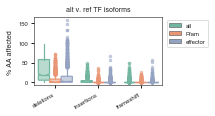

In [87]:
fig = plt.figure(figsize=(2.3, 1.25))
ax = sns.boxplot(data=to_plot[to_plot["n_or_perc"] == "perc"], 
                 x="type", y="value", hue="dom_cat", order=["dd", "ins", "f"],
                 palette=sns.color_palette("Set2"), fliersize=5, notch=True,
                 flierprops={"marker": "."})
mimic_r_boxplot(ax)


ax.set_xlabel("")
ax.set_xticklabels(["deletions", "insertions", "frameshift"], rotation=30, ha="right", va="top")
ax.set_ylabel("% AA affected")
ax.set_title("alt v. ref TF isoforms")
handles, labels = ax.get_legend_handles_labels()
labels = ["all", "Pfam", "effector"]
ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.01, 1))
fig.savefig('../../figures/fig1/domain-overall-boxplot.pdf',
            bbox_inches='tight')

In [88]:
to_plot[to_plot["n_or_perc"] == "perc"].groupby(["type", "dom_cat"]).agg("median")

value
type dom_cat            
dd   effector   1.768173
     pfam       0.000000
     total     18.681319
f    effector   0.000000
     pfam       0.000000
     total      0.000000
ins  effector   0.000000
     pfam       0.000000
     total      0.503356

In [89]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_f_dom"] > 0])

146

In [90]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_ins"] >= 10])

195

In [91]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_f"] >= 10])

68

In [92]:
len(ref_alt_map_nonan)

2305

In [93]:
214/2305

0.0928416485900217

In [94]:
len(ref_alt_map_nonan[(ref_alt_map_nonan["perc_dd_eff"] > 0) |
                      (ref_alt_map_nonan["perc_ins_eff"] > 0) |
                      (ref_alt_map_nonan["perc_f_eff"] > 0)])

1331

In [95]:
684/2305

0.2967462039045553

## 8. calculate domains that are affected compared to null

In [96]:
clans = load_pfam_clans()
dbd = load_DNA_binding_domains()

In [97]:
pfam = pd.read_csv('../../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])

In [98]:
ref_isos = dict([(tf.name, orf.name)
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript])
ref_isos['TBX5']

'TBX5-201'

In [99]:
# now every comparison is alt vs annotated reference isoform
df = pd.concat([g.aa_feature_disruption(ref_isos[g.name]) for g in tfs.values() if g.has_MANE_select_isoform])
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,0
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,0
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,0
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,0
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,0


In [100]:
len(df.gene_symbol.unique())

906

In [101]:
len(df.ref_iso.unique())

906

In [102]:
len(df.alt_iso.unique())

2298

In [103]:
df['is_DBD'] = df['accession'].isin(dbd['pfam'].values) | df['accession'].str.startswith('C2H2_ZF_array')
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift,is_DBD
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,0,True
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,0,True
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,0,True
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,0,False
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,0,False


In [104]:
# TODO: move to isolib.py
df['is_affected_at_all'] = (df['deletion'] + df['insertion'] + df['frameshift']) > 0
for frac in [1.0, 0.9, 0.5, 0.1]:
    df[f"is_affected_{frac * 100:.0f}pct"] = (df['deletion'] + df['insertion'] + df['frameshift']) >= frac * df['length']

dbd_acc = set(dbd['pfam'].values).union(
            set(df['accession'][df['accession'].str.startswith('C2H2_ZF_array')].unique())
            )

In [105]:
dbd['clan'] = dbd['pfam'].map(clans)
dbd['num_genes'] = dbd['pfam'].map(df.groupby('accession')['gene_symbol'].size())

In [106]:
def is_DBD(domain):
    return (domain.accession in dbd['pfam'].values) or domain.accession.startswith('C2H2_ZF_array')

n_aa_dbd = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if is_DBD(dom)]
n_aa_pfam = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'Pfam_domain']
n_aa_effector = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'effector_domain']

In [107]:
df.loc[df['accession'].str.startswith('C2H2_ZF_array'), 'accession'] = 'C2H2_ZF_array'
doms = (df.loc[(df['category'] == 'Pfam_domain') | 
              (df['category'] == 'ZF_array'), :]
              .groupby('accession')
              ['alt_iso']
              .nunique()
              .to_frame(name='n_alt_iso'))
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
                        (df['category'] == 'ZF_array'), :]
                        .groupby(['accession', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='accession'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)

In [109]:
%%time
df_null = pd.concat([g.null_fraction_per_aa_feature(ref_isos[g.name]) for g in tfs.values() if g.has_MANE_select_isoform])
df = pd.merge(df, df_null, how='left', on=['gene_symbol', 'ref_iso', 'alt_iso', 'length'])

CPU times: user 2min 22s, sys: 770 ms, total: 2min 23s
Wall time: 2min 23s


In [112]:
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,...,is_affected_at_all,is_affected_100pct,is_affected_90pct,is_affected_50pct,is_affected_10pct,null_fraction_affected_at_all,null_fraction_affected_100pct,null_fraction_affected_90pct,null_fraction_affected_50pct,null_fraction_affected_10pct
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,...,False,False,False,False,False,0.032695,0.015152,0.016746,0.024721,0.031100
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,...,False,False,False,False,False,0.098884,0.072568,0.073365,0.077352,0.080542
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,...,False,False,False,False,False,0.117225,0.072568,0.073365,0.077352,0.080542
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,...,False,False,False,False,False,0.037898,0.000000,0.000000,0.000000,0.032730
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,...,True,False,False,False,False,0.186908,0.038760,0.043066,0.062877,0.082687


In [113]:
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.loc[(df['category'] == 'Pfam_domain') |
                    (df['category'] == 'ZF_array'), :]
                .groupby(['accession', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('accession').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('accession').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('accession').apply(null_quantile, 0.5)

In [114]:
doms['is_DBD'] = doms.index.isin(dbd['pfam'].values) | (doms.index == 'C2H2_ZF_array')
# Use the custom DBD names
doms.loc[doms['is_DBD'], 'domain_name'] = doms[doms['is_DBD']].index.map(dbd.set_index('pfam')['dbd'])
doms.loc[~doms['is_DBD'], 'domain_name'] = doms[~doms['is_DBD']].index.map(pfam.set_index('pfam_accession')['name'])
doms.loc[doms.index == 'C2H2_ZF_array', 'domain_name'] = ['C2H2 ZF array']

In [115]:
dom_affected_levels = [c[5:] for c in doms.columns if c.startswith('f_is_affected_')]
level_desc = {'affected_at_all': 'at least partial domain removal',
 'affected_100pct': '100% removal',
 'affected_90pct': '90% removal',
 'affected_50pct': '50% removal',
 'affected_10pct': '10% removal'}

In [116]:
# all domains, all DBD, non-DBD
doms = df.groupby('is_DBD')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['is_DBD', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='is_DBD'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']


doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['is_DBD', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('is_DBD').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('is_DBD').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('is_DBD').apply(null_quantile, 0.5)
doms.head()

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,...,null_fraction_affected_100pct_center,null_fraction_affected_90pct_99CI_low,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center
is_DBD,,,,,,,,,,,,,,,,,,,,,
False,2265,1733.0,0.765121,1002.0,0.442384,1037.0,0.457837,1258.0,0.555408,1597.0,...,0.562031,0.556733,0.585430,0.571302,0.610155,0.639294,0.624724,0.683444,0.712583,0.698013
True,2129,990.0,0.465007,724.0,0.340066,734.0,0.344763,816.0,0.383279,947.0,...,0.418976,0.411461,0.441522,0.426491,0.450446,0.482386,0.466416,0.508690,0.542508,0.525599


In [117]:
df['category_a'] = np.nan
df.loc[df['is_DBD'], 'category_a'] = 'DBD'
df.loc[(df['category'] == 'Pfam_domain') & ~df['is_DBD'], 'category_a'] = 'Other Pfam domain'
df.loc[(df['category'] == 'effector_domain'), 'category_a'] = 'Effector domain'

In [118]:
# split pfam into dbd and 
doms = df.groupby('category_a')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['category_a', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='category_a'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)

    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['category_a', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('category_a').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('category_a').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('category_a').apply(null_quantile, 0.5)

data = doms.copy()

In [119]:
df.columns

Index(['gene_symbol', 'ref_iso', 'alt_iso', 'accession', 'category',
       'start_in_ref_iso', 'end_in_ref_iso', 'length', 'deletion', 'insertion',
       'frameshift', 'is_DBD', 'is_affected_at_all', 'is_affected_100pct',
       'is_affected_90pct', 'is_affected_50pct', 'is_affected_10pct',
       'null_fraction_affected_at_all', 'null_fraction_affected_100pct',
       'null_fraction_affected_90pct', 'null_fraction_affected_50pct',
       'null_fraction_affected_10pct', 'category_a'],
      dtype='object')

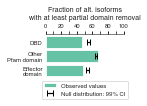

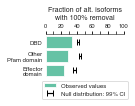

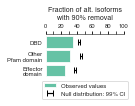

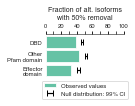

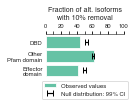

In [122]:
for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(1.4, 0.8)
        # removing C2H2-ZF clan becuase we look at the ZF arrays instead
        ax.barh(data.index, 
                data[f'f_is_{level}'].values * 100,
                label='Observed values',
                color=sns.color_palette("Set2")[0])
        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.55))
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_yticklabels(["DBD", "Other\nPfam domain", "Effector\ndomain"])
        ax.set_xlabel(f'Fraction of alt. isoforms\nwith {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        plt.savefig(f'../../figures/fig1/domain_categories_{level}.resized.pdf'.format(level),
                bbox_inches='tight')